In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from agnfinder.tf_sampling import deep_emulator
from agnfinder.prospector import load_photometry

from matplotlib.ticker import PercentFormatter, ScalarFormatter, MaxNLocator

In [34]:
import seaborn as sns
sns.set_context('paper')
# sns.set(font_scale=1.8)

sns.set()

In [35]:
os.chdir('/home/walml/repos/agnfinder')

In [36]:
euclid_band_names = ['u', 'g', 'r', 'i', 'z', 'H', 'J', 'Y']

In [37]:

checkpoint_dir = 'results/checkpoints/latest'



In [38]:

x_train, y_train, x_test, y_test = deep_emulator.data(cube_dir='data/cubes/latest', rescale=True)

x_train, y_train = x_train[:10000], y_train[:10000]  # for speed
x_test, y_test = x_test[:10000], y_test[:10000]  # for speed

emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

emulator.evaluate(x_train, y_train, use_multiprocessing=True)
emulator.evaluate(x_test, y_test, use_multiprocessing=True)

y_pred = emulator.predict(x_test, use_multiprocessing=True)

print('Explained Var (max 1): {:.5f}'.format(metrics.explained_variance_score(y_test, y_pred)))

# bands = np.arange(y_train.shape[1])
bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H','VISTA_J', 'VISTA_Y']
med_abs_error = np.array([metrics.median_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(bands))])
rel_med_abs_error = med_abs_error / np.median(y_test, axis=0)
r2 = np.array([metrics.r2_score(y_test[:, i], y_pred[:, i]) for i in range(len(bands))])

print('Median absolute error: {}'.format(med_abs_error))
print('Relative median absolute error: {}'.format([('{:.2f}'.format(100 * x) +r'%') for x in rel_med_abs_error]))
print('R2 Score: {}'.format(r2))



10000/10000 [==============================] - 0s 38us/sample - loss: 1.8266e-04 - mean_squared_error: 4.4410e-05
Explained Var (max 1): 0.39267
Median absolute error: [1.17608702e-04 8.79009033e-05 7.66674456e-05 5.18392027e-05
 5.89854188e-05 1.02482604e-04 6.25582357e-05 5.97464332e-05]
Relative median absolute error: ['0.09%', '0.07%', '0.06%', '0.04%', '0.05%', '0.09%', '0.05%', '0.05%']
R2 Score: [0.62996633 0.51204645 0.18828109 0.1447321  0.3617956  0.11007064
 0.20312144 0.99074587]


In [39]:
def metric_by_band(metric, y_true, y_pred):
    bands = ['a', 'b', 'c', 'd', 'e', 'f', 'g','h']  # TODO
    return [(band, metric(y_true[:, i], y_pred[:, i])) for i, band in enumerate(bands)]


def maggies_to_mags(maggies):
     # inverse of load_photometry.mags_to_maggies
    return -2.5 * np.log10(maggies)


In [40]:

# overriding above
x_test = np.loadtxt('data/cubes/x_matched_unfiltered.npy')
y_test = np.loadtxt('data/cubes/y_matched_unfiltered.npy')
y_test = y_test / y_test.sum(axis=1, keepdims=True)  # normalise targets, will unnorm later
y_pred = emulator.predict(x_test, use_multiprocessing=True)

In [41]:
class Result():
    
    def __init__(self, band_i, band, x_test, y_test):
        self.band = band
        self.band_i = band_i
        self.scale = y_test.sum(axis=1, keepdims=True)
        self.true_flux = deep_emulator.denormalise_photometry(np.expand_dims(y_test[:, self.band_i], axis=1), scale=self.scale)
        self.predicted_flux = deep_emulator.denormalise_photometry(np.expand_dims(y_pred[:, self.band_i], axis=1), scale=self.scale)
        
#         self.true_log_flux = y_test[:, band_i]
        
        self.flux_abs_error = np.abs(self.true_flux - self.predicted_flux)
        self.fractional_flux_error = self.flux_abs_error / self.true_flux
        
        self.true_mags = maggies_to_mags(self.true_flux)
        self.predicted_mags = maggies_to_mags(self.predicted_flux)
        
            # around .1 mags, reasonable but quite a bit higher than speculator? Depends on priors of course
        self.mags_abs_error = np.abs(self.true_mags - self.predicted_mags)
        # 0-1%, fairly good - directly proportional to loss target, so makes sense
        self.fractional_mag_error = self.mags_abs_error / self.true_mags

In [42]:
results = []
for i, band in enumerate(euclid_band_names):
    results.append(Result(i, band, x_test, y_test))

In [43]:
results

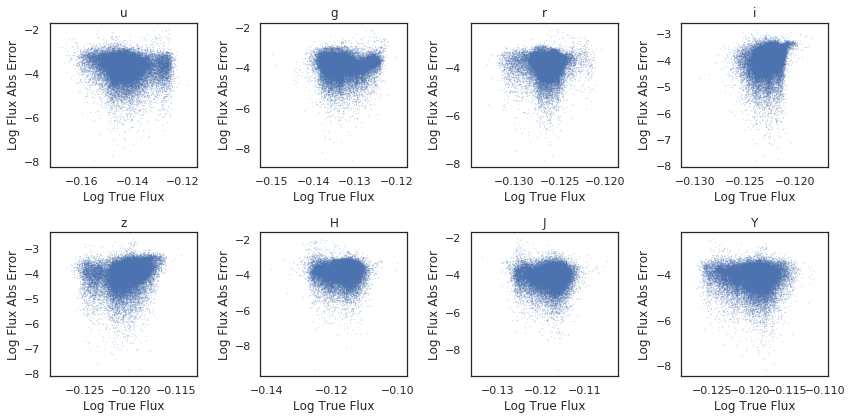

In [44]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

#     flux errors by flux
#     absolute errors get bigger as the flux gets bigger, which is not surprising
    ax.scatter(np.log10(result.true_flux), np.log10(result.flux_abs_error), alpha=0.3, s=0.1)
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_ylim(0., .2)
    ax.set_xlabel('Log True Flux')
    ax.set_ylabel('Log Flux Abs Error')
fig.tight_layout()


In [45]:
result.true_flux

array([[0.75520203],
       [0.75847052],
       [0.76217985],
       ...,
       [0.76593994],
       [0.7581051 ],
       [0.74850646]])

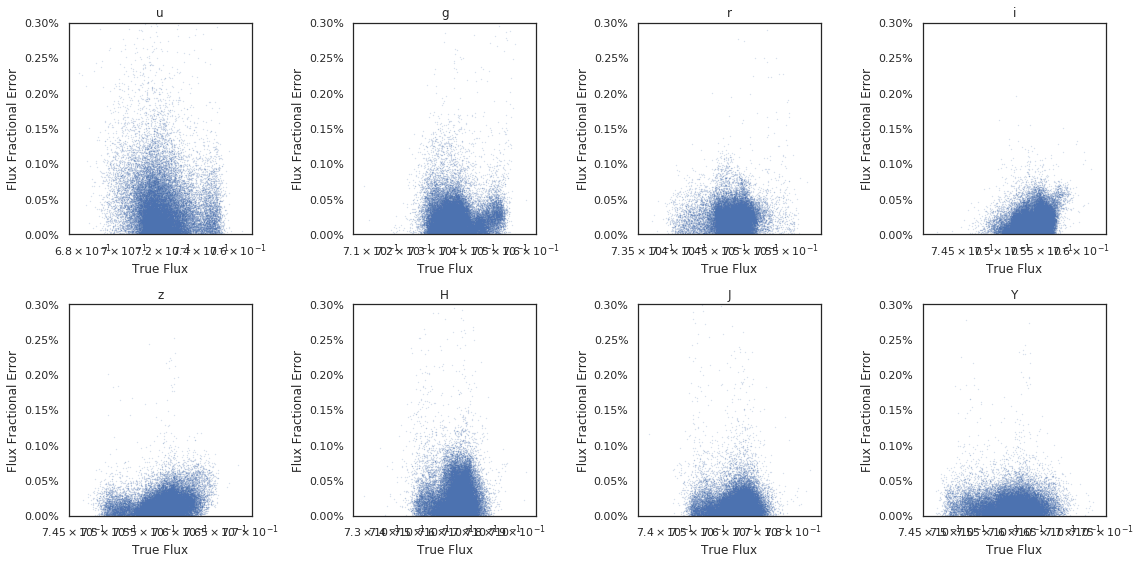

In [46]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    # fractional flux errors by flux
    # typical fractional flux errors of around 5%
    # fractional error is fairly constant, which I guess is good
    ax.scatter(result.true_flux, result.fractional_flux_error * 100., alpha=0.3, s=0.1)
    # ax.set_yscale('log')
    ax.set_xscale('log')
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    ax.set_ylim(0., .3)
    ax.set_xlabel('True Flux')
    ax.set_ylabel('Flux Fractional Error')
fig.tight_layout()




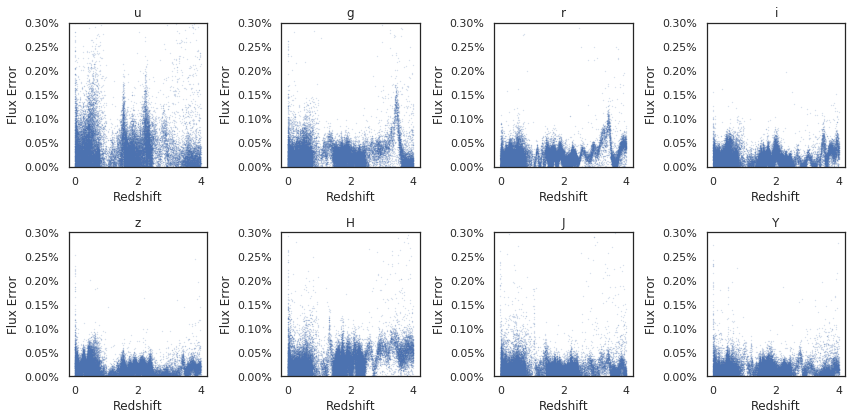

In [47]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    redshifts = x_test[:, 0] * 4  # denormalise
    ax.scatter(redshifts, result.fractional_flux_error * 100., alpha=0.3, s=0.1)
    ax.set_ylim(0., .3)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Flux Error')
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))

fig.tight_layout()


In [48]:

def plot_param_performance_all_bands(param, label):
    sns.set_style('white')
    fig, ax = plt.subplots()

    param_tiled = np.tile(param, len(results)).squeeze()  # denormalise
    all_errors = []

    for result in results:
        all_errors.append(result.fractional_flux_error.flatten() * 100.)

    all_errors = np.array(all_errors).flatten().squeeze()
    ax.scatter(param_tiled, all_errors, alpha=0.4, s=0.1)
    # sns.jointplot(x=redshifts, y=all_errors, kind='hex')
    # ax.set_ylim(0., .1)
    ax.set_xlim(0, None)
    ax.set_ylim(0., .3)
    ax.set_xlabel(label)
    ax.set_ylabel('Flux Error')
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))

    fig.tight_layout()


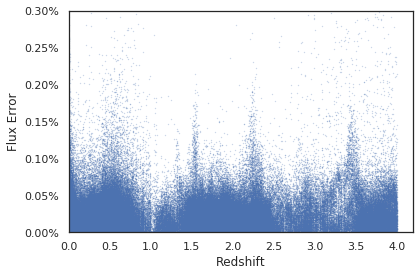

In [49]:
param = x_test[:, 0] * 4
label = 'Redshift'
plot_param_performance_all_bands(param, label)

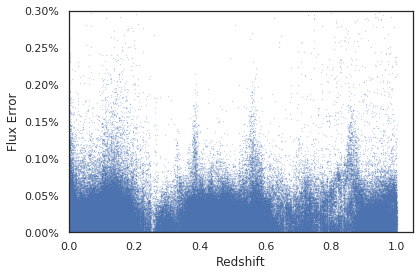

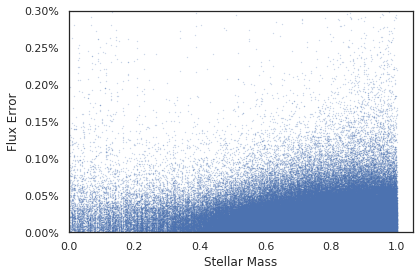

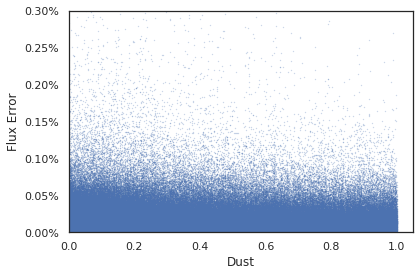

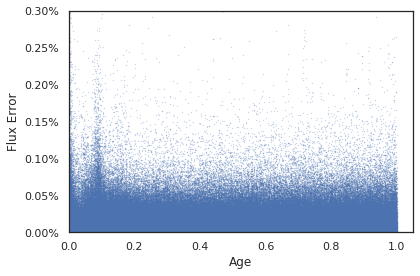

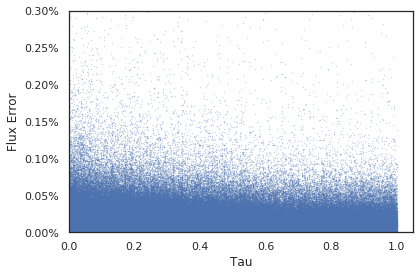

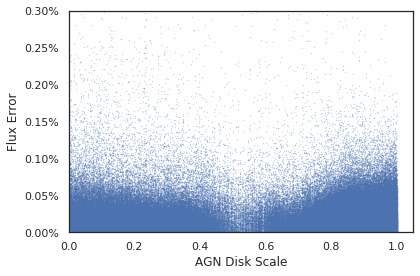

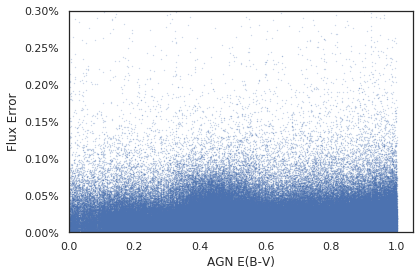

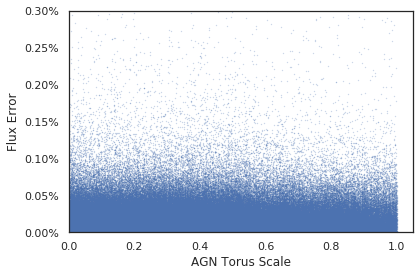

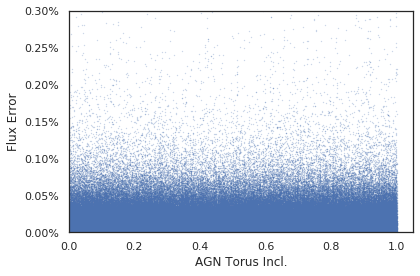

In [50]:
param_names = ['Redshift', 'Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
for param_n, label in enumerate(param_names):
    param = x_test[:, param_n]
    plot_param_performance_all_bands(param, label)

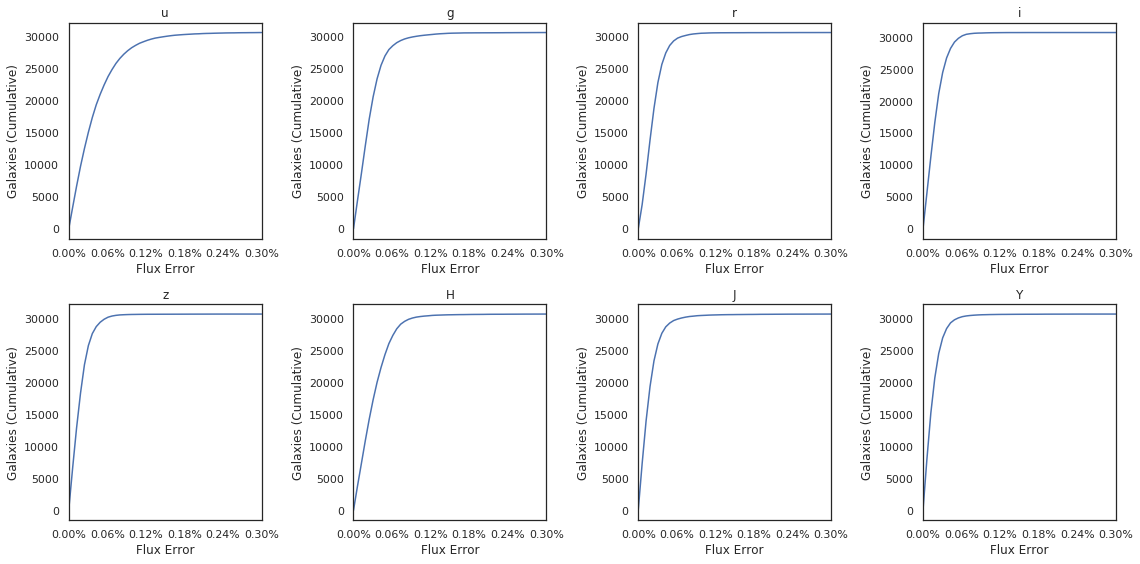

In [51]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    # mag errors
#     x_max = np.percentile(result.fractional_flux_error, 99.9)
    x_max = 0.3
    x = np.linspace(0, x_max)
    below_x = np.array([np.sum(result.fractional_flux_error * 100 < max_error) for max_error in x])
    ax.plot(x, below_x)
    ax.set_title(result.band)
    ax.set_xlabel('Flux Error')
    ax.set_ylabel('Galaxies (Cumulative)')
    ax.xaxis.set_major_formatter(PercentFormatter(decimals=2))
    ax.xaxis.set_major_locator(MaxNLocator(5))  # more is cluttered
    ax.set_xlim([0., 0.3])


fig.tight_layout()


In [91]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

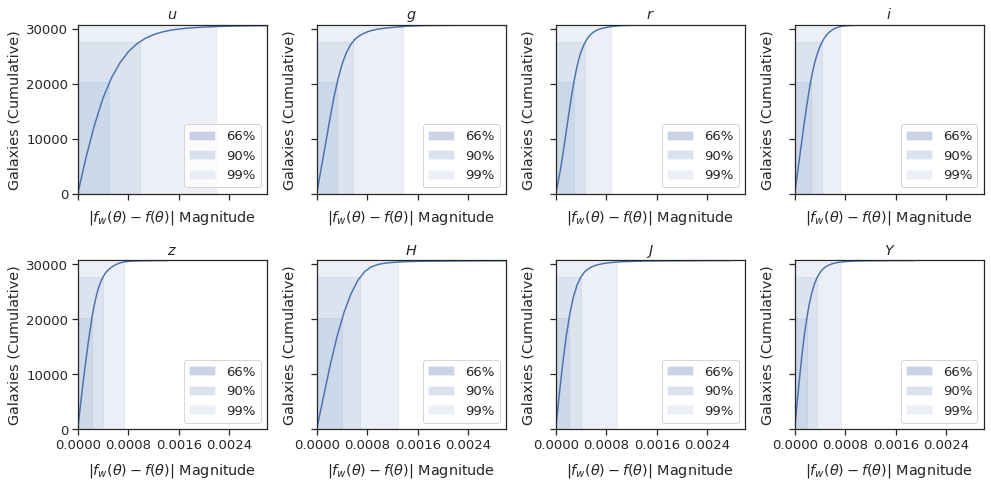

In [139]:

sns.set(font_scale=1.2)
sns.set_style('ticks')

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), sharex=True, sharey=True)
all_axes = [ax for row in axes for ax in row]
# percentiles = np.array([66, 90, 99, 99.9, 100.])
percentiles = np.array([66, 90., 99.])

for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    # mag errors
    x_max = np.percentile(result.mags_abs_error, 99.9)
#     x_max = 0.005
    x = np.linspace(0, x_max)
    below_x = np.array([np.sum(result.mags_abs_error < max_error) for max_error in x])
    
    mag_error_at_percentiles = np.percentile(result.mags_abs_error, percentiles)
    galaxies_at_percentiles = len(result.mags_abs_error) * percentiles / 100.
    for n in range(len(percentiles)):
        xf = np.linspace(0, mag_error_at_percentiles[n])
        y1 = np.zeros(50)
        y2 = np.ones(50) * galaxies_at_percentiles[n]
        ax.fill_between(xf, y1, y2, alpha=0.1, color='b', label=percentiles[n])
#      ax.axvline() for e in ]
#     [ax.axhline(n) for n in galaxies_at_percentiles]

#         if n == 0:
#             xf = np.linspace(0, mag_error_at_percentiles[n])
#         else:
#             xf = np.linspace(mag_error_at_percentiles[n-1], mag_error_at_percentiles[n])
#         y1 = np.zeros(50)
#         y2 = np.ones(50) * galaxies_at_percentiles[n]
#         ax.fill_between(xf, y1, y2, alpha=0.1)
    
    ax.plot(x, below_x)
    ax.set_title(f'${result.band}$')
    labelpad_x = 15
    labelpad_y =  20
#     print(result.band_i)
    if (result.band_i == 0) or (result.band_i == 4):
        labelpad_y = 5
    if result.band_i > 3:
        labelpad_x = 10
#     print(labelpad)
    ax.set_xlabel(r'$|{f_w}(\theta) - f(\theta)|$ Magnitude', labelpad=labelpad_x)
    ax.set_ylabel('Galaxies (Cumulative)', labelpad=labelpad_y)
    ax.set_ylim([0, len(result.mags_abs_error)])
    ax.set_xlim([0, 0.003])
    ax.xaxis.set_major_locator(MaxNLocator(4))  # more is cluttered

#     ax.legend()

    alphas = {0: 0.3, 1: 0.2, 2: 0.1}
    legend_elements = [Patch(facecolor='b', alpha=alphas[n], label=str(pc)[:2] + '%') for n, pc in enumerate(percentiles)]
    ax.legend(handles=legend_elements, loc='lower right')
    
fig.tight_layout()
fig.savefig('emulator_mag_errors.pdf')

In [117]:
type(result.band_i)

int

In [69]:
n_galaxies_at_percentiles

array([0.00035737, 0.00072655, 0.00189154, 0.0056945 ])

In [73]:
galaxies_at_percentiles

array([20265.96 , 27635.4  , 30398.94 , 30675.294, 30706.   ])

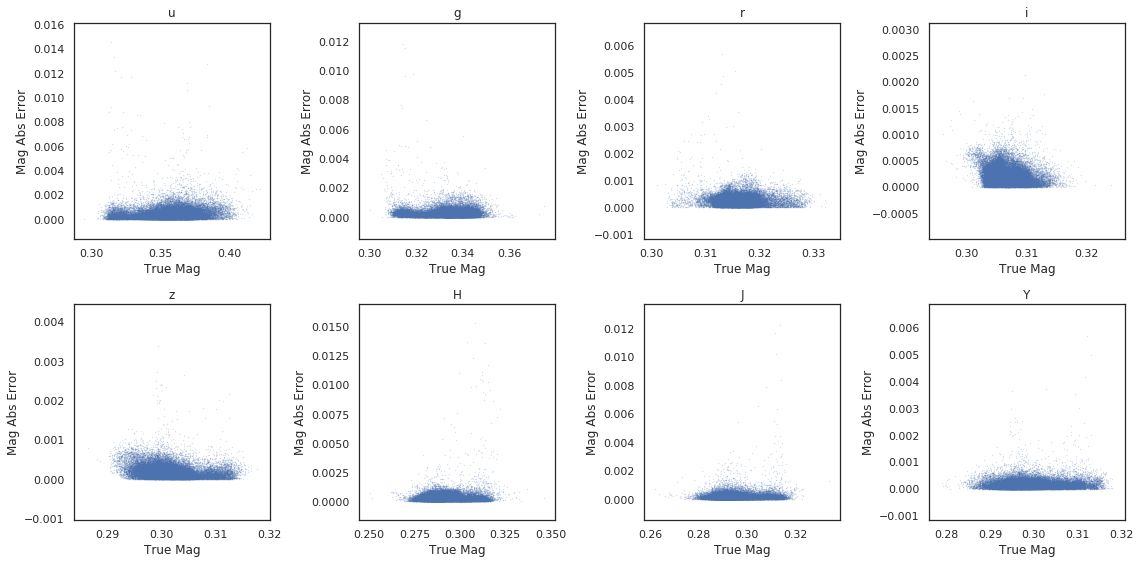

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    # mag error by mag
    ax.scatter(result.true_mags, result.mags_abs_error, alpha=0.3, s=0.1)
#     ax.set_ylim(0., .2)
    ax.set_xlabel('True Mag')
    ax.set_ylabel('Mag Abs Error')



fig.tight_layout()


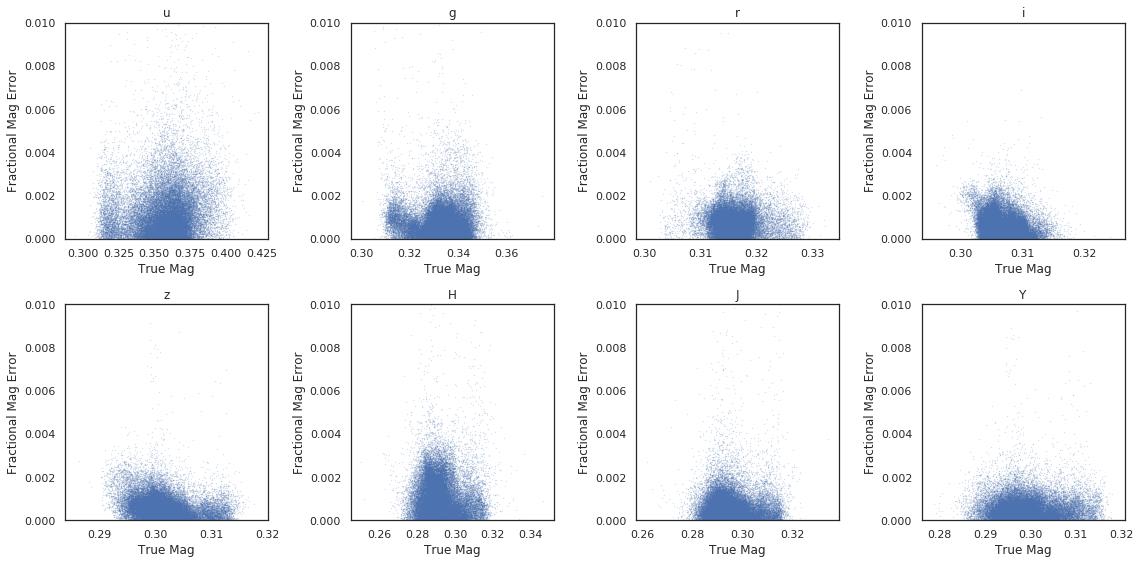

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
all_axes = [ax for row in axes for ax in row]
for result in results:
    ax = all_axes[result.band_i]
    ax.set_title(result.band)

    # fractional mag error by mag
    # typical fractional mag errors of around 0.5%
    ax.scatter(result.true_mags, result.fractional_mag_error, alpha=0.3, s=0.1)
    ax.set_ylim(0., .01)
    ax.set_xlabel('True Mag')
    ax.set_ylabel('Fractional Mag Error')

fig.tight_layout()


In [55]:
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
# all_axes = [ax for row in axes for ax in row]
# for result in results:
#     ax = all_axes[result.band_i]
#     ax.set_title(result.band)


#     # mag error by redshift
#     redshifts = x_test[:, 0]
#     ax.scatter(redshifts, result.mags_abs_error, alpha=0.3, s=0.1)
#     # ax.set_ylim(0., .2)
#     ax.set_ylim(0., .004)
#     ax.set_xlabel('Redshift (/4)')
#     ax.set_ylabel('Mag Abs Error')


# fig.tight_layout()


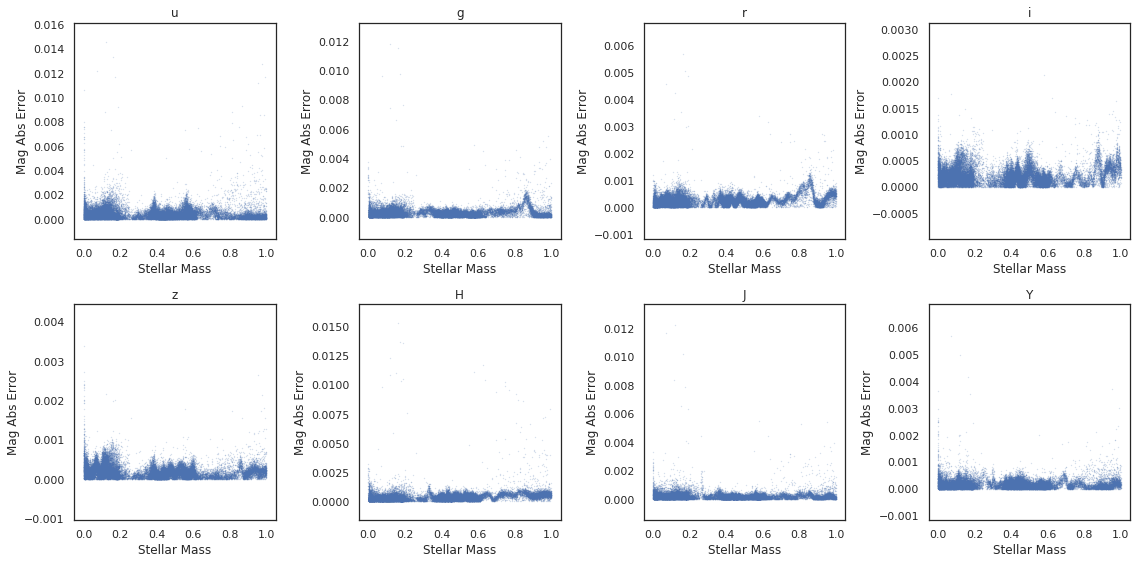

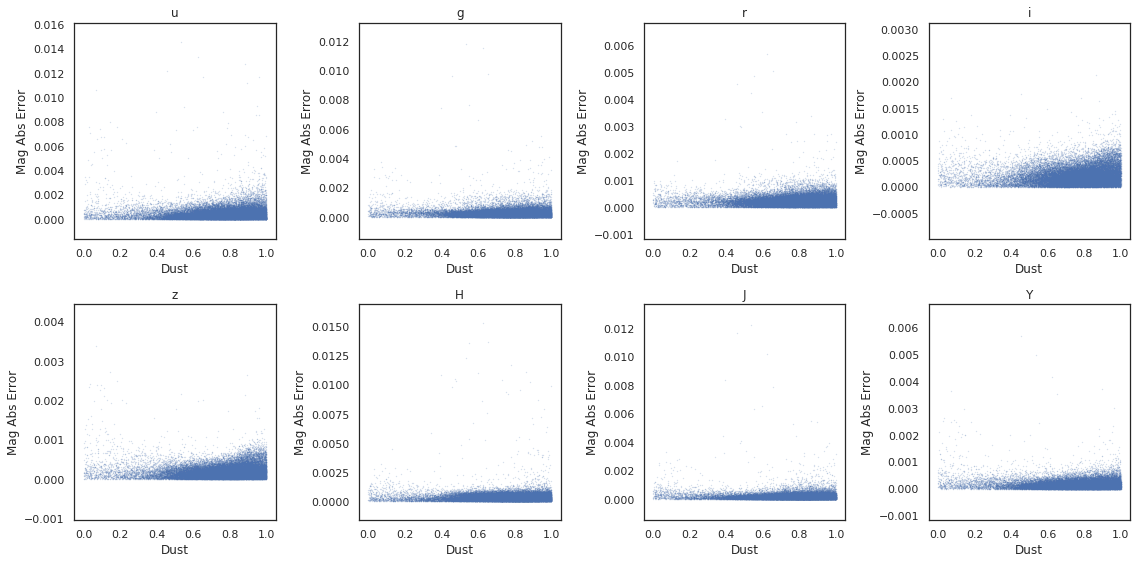

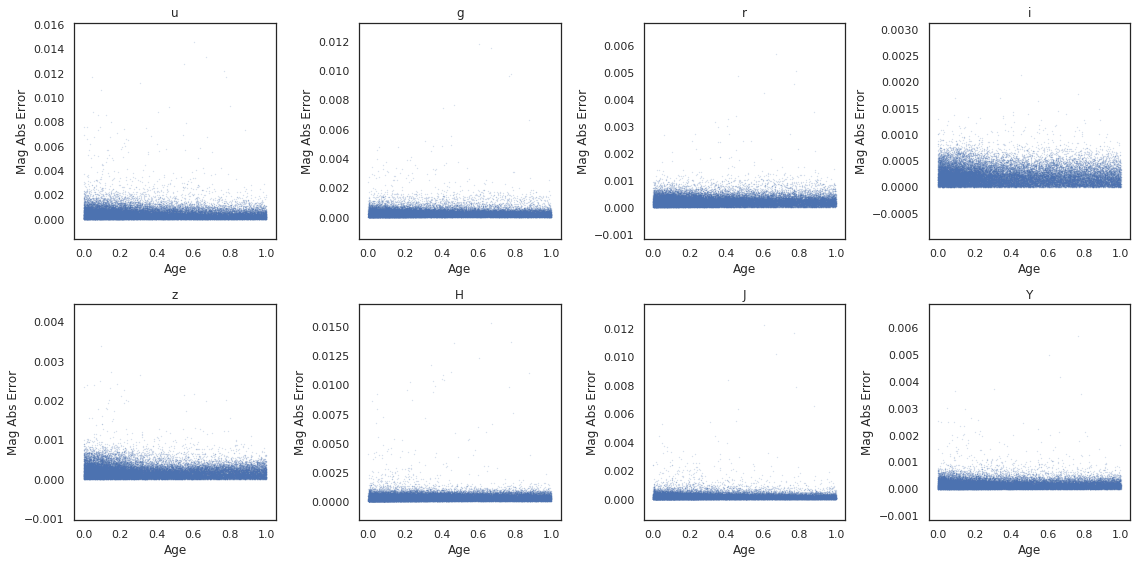

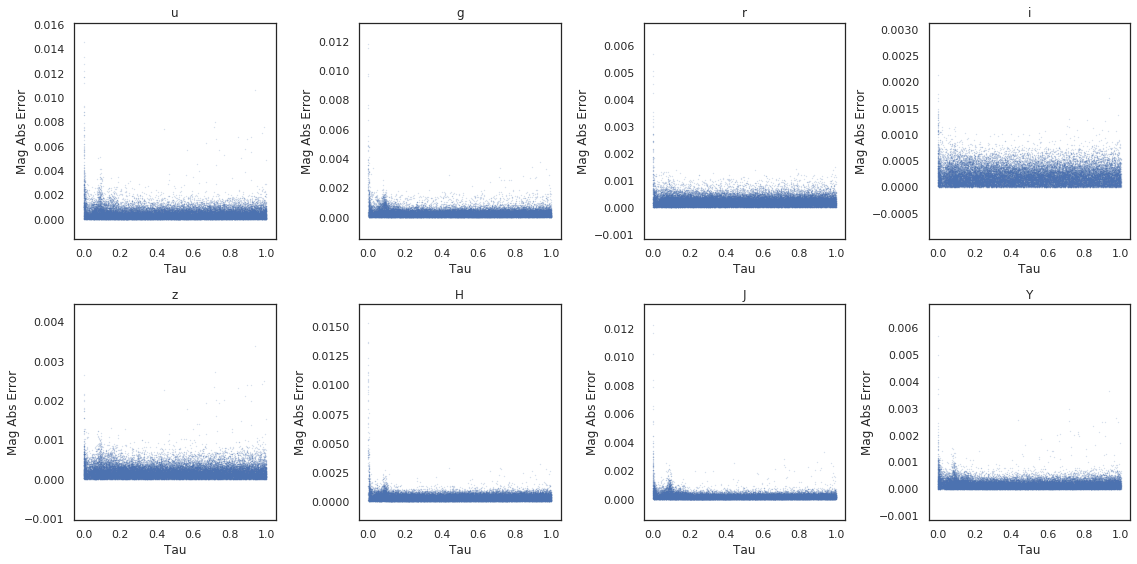

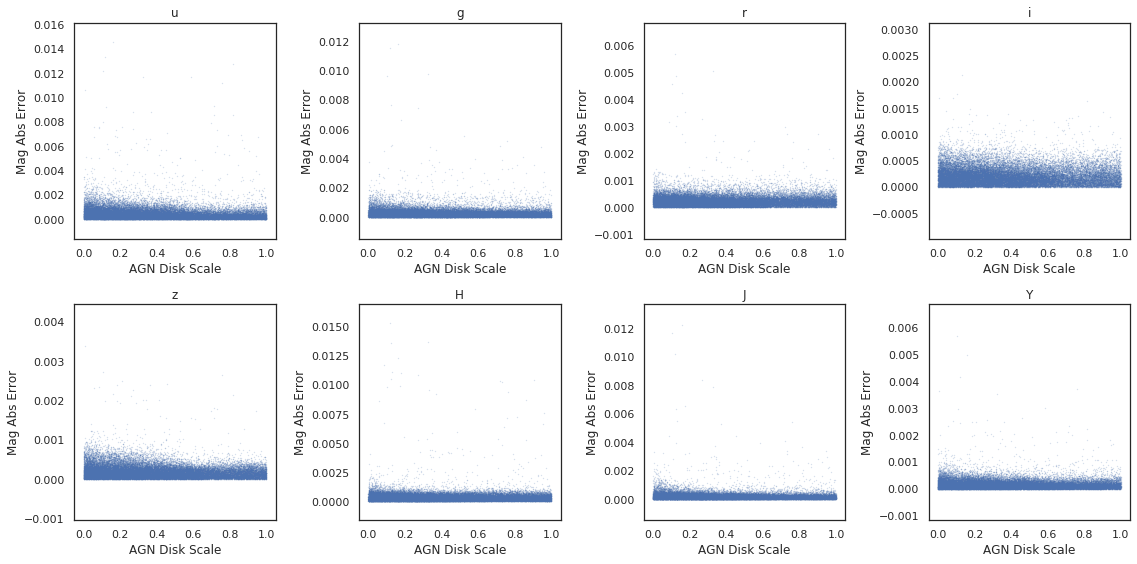

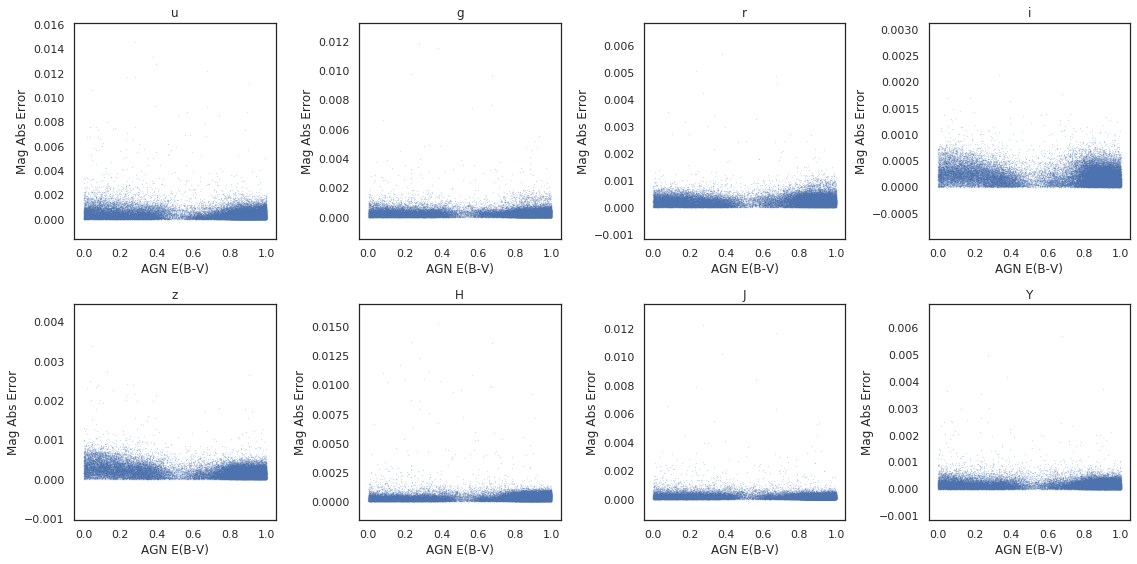

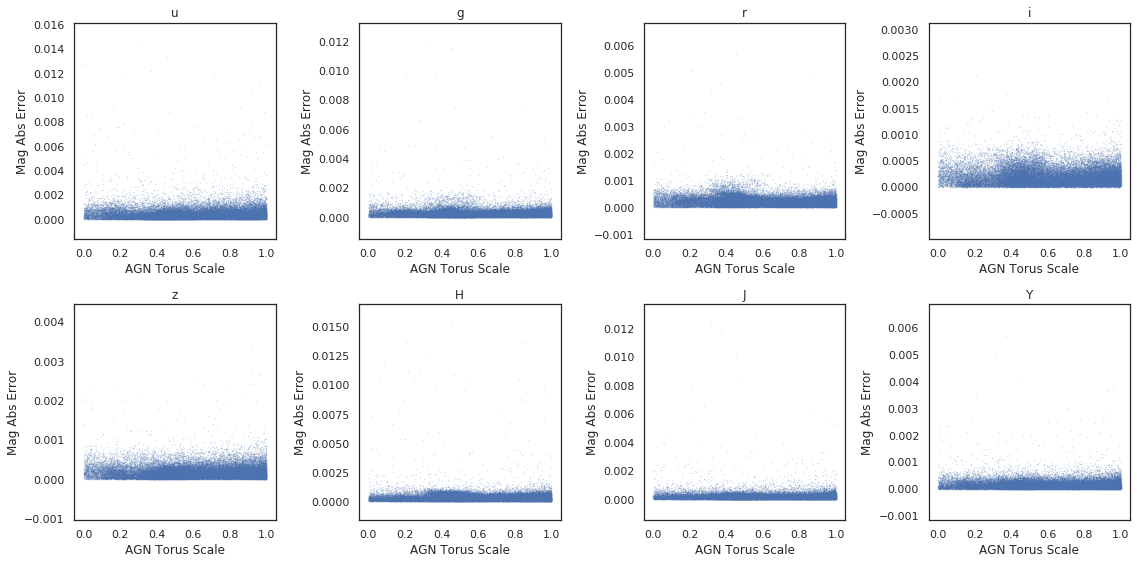

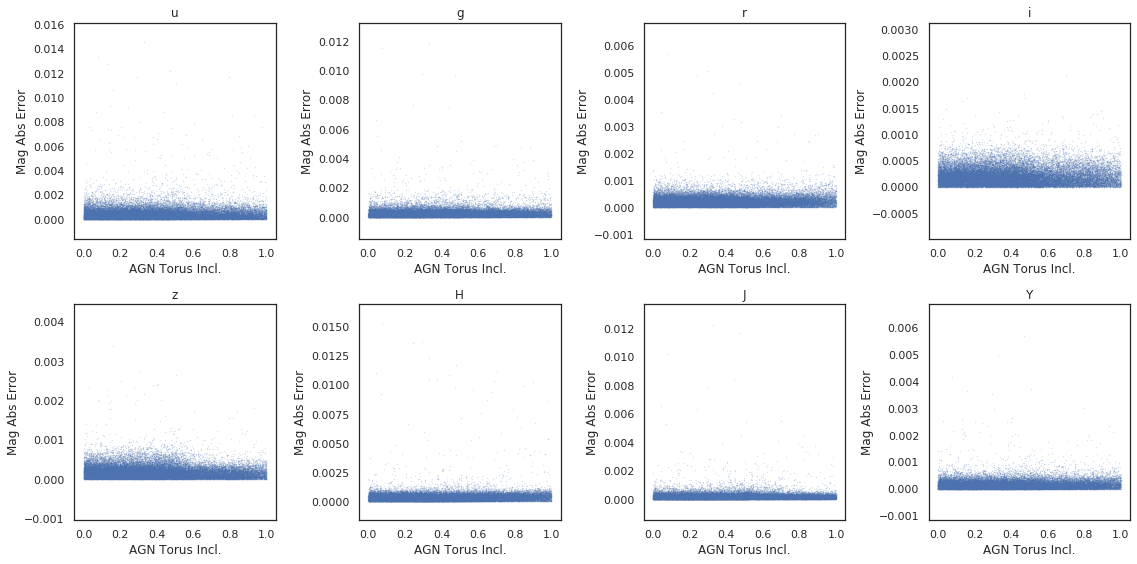

In [56]:
param_names = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
for param_n, param_name in enumerate(param_names):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    all_axes = [ax for row in axes for ax in row]
    for result in results:
        ax = all_axes[result.band_i]
        ax.set_title(result.band)

        param = x_test[:, param_n]
        ax.scatter(param, result.mags_abs_error, alpha=0.3, s=0.1)
#         ax.set_ylim(0., .2)
        ax.set_xlabel(param_name)
        ax.set_ylabel('Mag Abs Error')

    fig.tight_layout()
